In [1]:
import rospy
import os
import time
import numpy as np
import torch
from nn_model import RollPitchAcclnModel
import pickle
import matplotlib.pyplot as plt

/home/aniket/Documents/MMAD/DOM_Planner/losi/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
with open("stats_physics.pkl", "rb") as f:
    stats = pickle.load(f)

    # model_path = "DOM_Planner/precession_all_data--02-16-00-46/.pth"
    model_path = "precession_all_data--02-16-00-46/no_norm--02-23-02-32-E53-best.pth"
    nnModel = RollPitchAcclnModel()
    nnModel.load_state_dict(torch.load(model_path)['model'])
    nnModel.cuda()
    nnModel.eval()

/tmp/ipykernel_304043/1605857716.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nnModel.load_state_dict(torch.load(model_path)['model'])


In [44]:
rpm = torch.zeros((100, 1), dtype=torch.float32).cuda() + 0  #torch.zeros((100, 1), dtype=torch.float32).cuda() + 1500
steering = torch.zeros((100, 1), dtype=torch.float32).cuda()
steering[:] = -1.0
angles = torch.zeros((100, 6), dtype=torch.float32).cuda()
angles[:, [1, 3, 5]] = 1.0
ang_vels = torch.zeros((100, 3), dtype=torch.float32).cuda()
ang_vels[:, 1] = 0.0
rpmdot = torch.linspace(0, -3480, 100).unsqueeze(1).cuda() 
steering_dot = torch.linspace(0, 6.5, 100).unsqueeze(1).cuda() * 0


# rpm_normalized = (rpm - stats['rpm_min']) / (stats['rpm_max'] - stats['rpm_min'])
# rpmdot_normalized = (rpmdot - stats['rpm_dot_mean']) / stats['rpm_dot_std']
# steering_dot = (steering_dot - stats['steering_dot_mean']) / stats['steering_dot_std']

(100, 3)
3.2504709


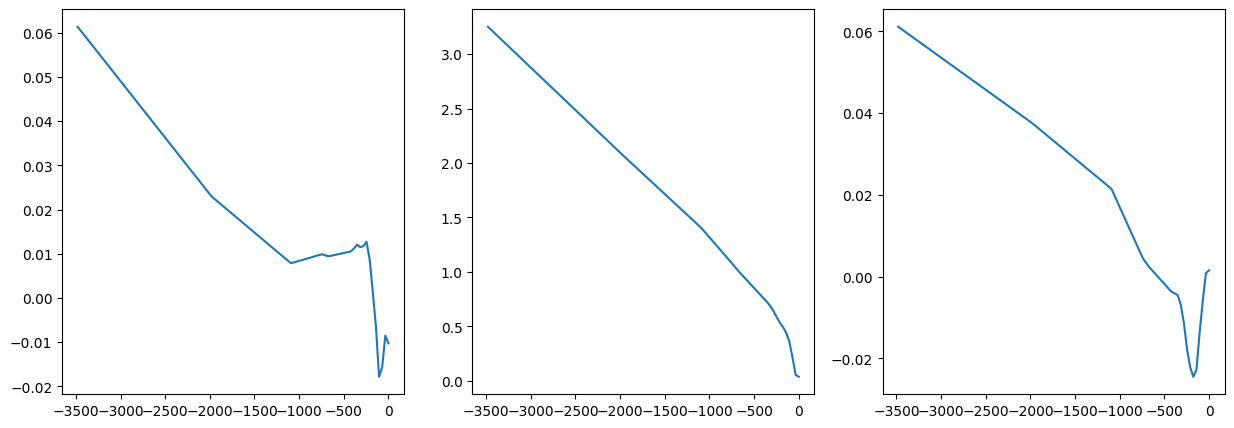

In [48]:
accelerations = nnModel(rpm, 
                    rpmdot, 
                    steering, 
                    steering_dot, 
                    angles, 
                    ang_vels
                    ).detach().cpu().numpy()
print(accelerations.shape)
print(accelerations[-1, 1])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(rpmdot.cpu().numpy(), accelerations[:, 0])
ax[1].plot(rpmdot.cpu().numpy(), accelerations[:, 1])
ax[2].plot(rpmdot.cpu().numpy(), accelerations[:, 2])

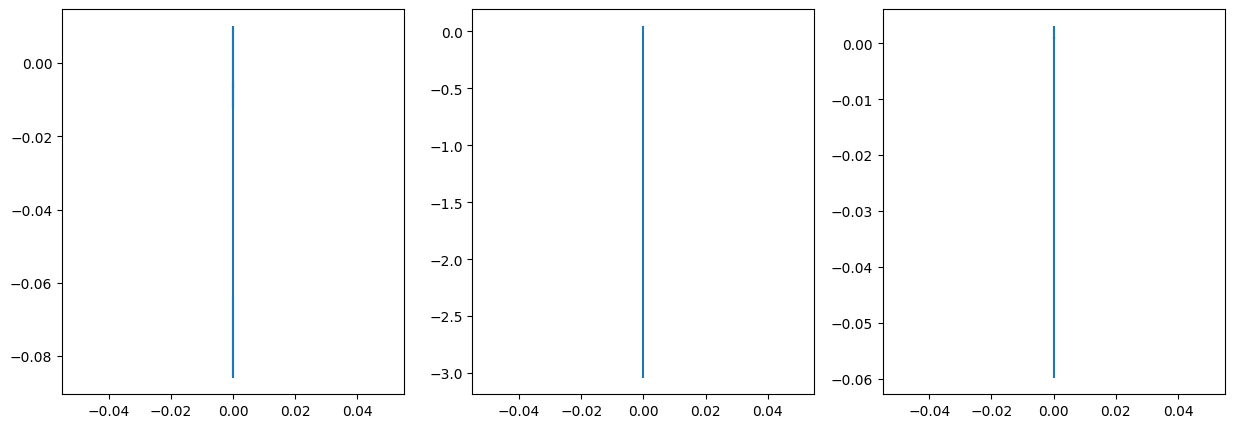

In [ ]:
pitch_scalar = -6.5
roll_scalar = 0.0

In [48]:
pitch_acc = torch.cos(steering*0.61) * rpmdot/3480 * pitch_scalar

roll_acc = (torch.sin(steering*0.61) * rpmdot/3480 * pitch_scalar) + (-rpm * steering_dot * 0.0001)

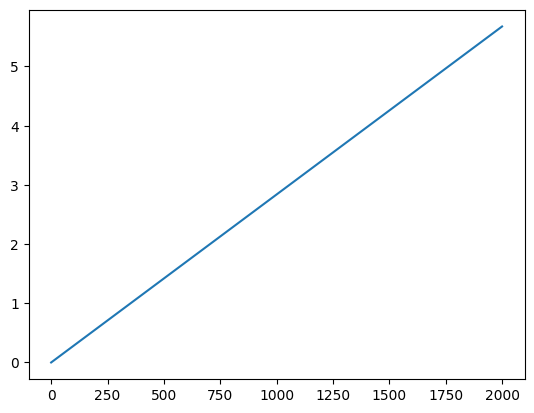

In [49]:
plt.plot(rpm.cpu().numpy(), roll_acc.cpu().numpy())

In [31]:
def model_dynamics(rpm, rpmdot, steering, steering_dot, dt):
    pitch_scalar = -4.4
    roll_scalar_acc_scalar = -1.35
    roll_precession_scalar = 0.0001

    rpm_min_mask = 0 - rpm > (rpmdot.min()*dt)
    rpm_max_mask = 1980 - rpm < (rpmdot.max()*dt)
    rpmdot[rpm_min_mask] = torch.maximum(rpmdot[rpm_min_mask], (0-rpm[rpm_min_mask])/dt)
    rpmdot[rpm_max_mask] = torch.minimum(rpmdot[rpm_max_mask], (1980-rpm[rpm_max_mask])/dt)
    
    steering_min_mask = -1.0 - steering > (steering_dot.min()*dt)
    steering_max_mask = 1.0 - steering < (steering_dot.max()*dt)
    steering_dot[steering_min_mask] = torch.maximum(steering_dot[steering_min_mask], (-1.0-steering[steering_min_mask])/dt)
    steering_dot[steering_max_mask] = torch.minimum(steering_dot[steering_max_mask], (1.0-steering[steering_max_mask])/dt)
    
    pitch_acc = torch.cos(steering*0.61) * (rpmdot/3480) * pitch_scalar
    roll_acc = (torch.sin(steering*0.61) * (rpmdot/3480) * roll_scalar_acc_scalar) + (-rpm * steering_dot * roll_precession_scalar)
    yaw_acc = torch.zeros_like(roll_acc)
    
    return torch.cat([roll_acc, pitch_acc, yaw_acc], dim=1)

(np.float32(0.0), np.float32(0.03336668))

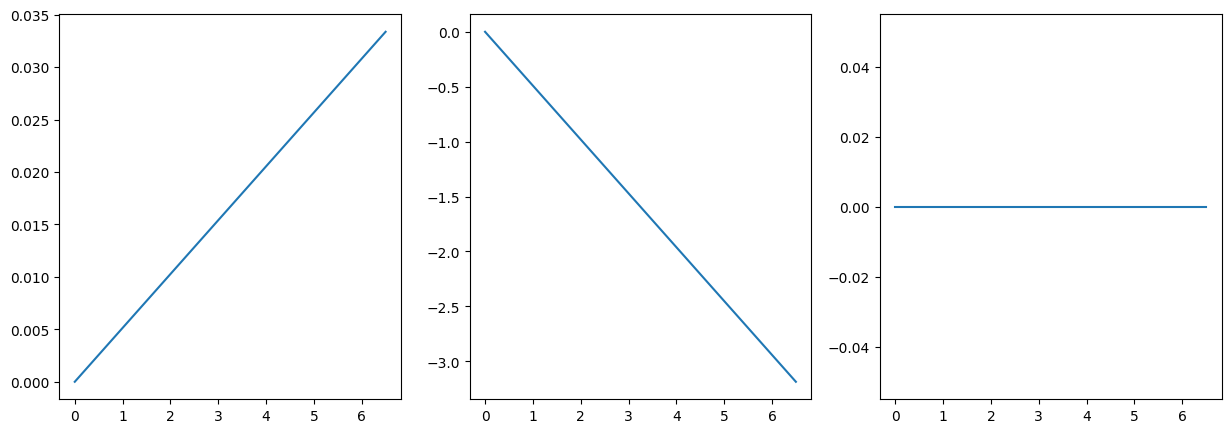

In [38]:
rpm = torch.zeros((100, 1), dtype=torch.float32).cuda() + 1000 #torch.linspace(0, 2000, 100).unsqueeze(1).cuda() 
steering = torch.zeros((100, 1), dtype=torch.float32).cuda()
steering[:] = -1.0
angles = torch.zeros((100, 6), dtype=torch.float32).cuda()
angles[:, [1, 3, 5]] = 1.0
ang_vels = torch.zeros((100, 3), dtype=torch.float32).cuda()
ang_vels[:, 1] = 0.0
rpm_dot = torch.linspace(0, 3075, 100).unsqueeze(1).cuda() 
steering_dot = torch.linspace(0, 6.5, 100).unsqueeze(1).cuda()

accelerations = model_dynamics(rpm.clone(), rpm_dot.clone(), steering.clone(), steering_dot.clone(), 0.1).cpu().numpy()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(steering_dot.cpu().numpy(), accelerations[:, 0])
ax[1].plot(steering_dot.cpu().numpy(), accelerations[:, 1])
ax[2].plot(steering_dot.cpu().numpy(), accelerations[:, 2])

accelerations[:, 0].min(), accelerations[:, 0].max()

In [2]:
a = torch.randn(100, 2)

In [4]:
a.mean(1).shape

torch.Size([100])